In [1]:
import h5py 
import numpy as np 
# -- astropy--
from astropy.io import fits
from astropy.table import Table as aTable
# -- feasibgs -- 
from feasibgs import util as UT

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in the block catalog
dir_spec = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/'])
fblock = h5py.File(''.join([dir_spec, 'g15.mockexp_block.hdf5']), 'r') 
block = {}
for g in fblock.keys():
    block[g] = {} 
    for k in fblock[g].keys(): 
        block[g][k] = fblock[g][k].value
fblock.close()
magnorm_flag = block['forwardmodel']['magnorm_flag']

In [4]:
r_mag_legacy = UT.flux2mag(block['legacy-photo']['flux_r'])#, method='log')
ztrue = block['gama-spec']['z']

In [5]:
iexp = 0 
exps = aTable.read(''.join([UT.dat_dir(), 'survey_exposures.fits']))

exp_i = exps[iexp]

In [6]:
zblock_ks = fits.open(''.join([dir_spec, 'g15.sim_spectra.mockexp_block.480.iexp', str(iexp), '.KSsky.rr.fits']))[1].data
zblock_newks = fits.open(''.join([dir_spec, 'g15.sim_spectra.mockexp_block.480.iexp', str(iexp), '.newKSsky.rr.fits']))[1].data

In [7]:
def zsuccess(zrr, ztrue, zwarn): 
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    return (dz_1pz < 0.003) & (zwarn == 0)# & magnorm_flag

In [8]:
ks_zsuccess = zsuccess(zblock_ks['Z'], ztrue, zblock_ks['ZWARN'])
newks_zsuccess = zsuccess(zblock_newks['Z'], ztrue, zblock_newks['ZWARN'])

In [9]:
def zsuccess_rate_magnorm(prop, zsuccess_cond, magnorm_flag, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop[magnorm_flag], bins=nbins, range=range)
    hv, _ = np.histogram(prop[magnorm_flag], bins=bins, weights=prop[magnorm_flag])
    h1, _ = np.histogram(prop[zsuccess_cond & magnorm_flag], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

In [10]:
exp_i['MOONFRAC'][0]

0.8027018323202668

Text(0.5,1,'Moon Ill. = 0.802702, Alt. = 31.072670, Sep. = 54.793890')

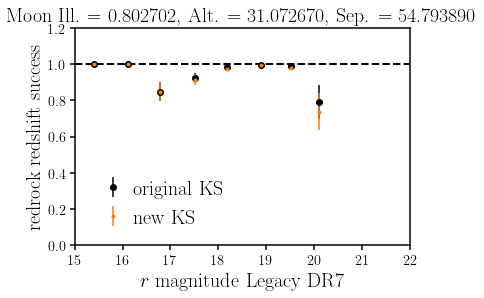

In [11]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, ks_zsuccess, magnorm_flag, nbins=10, range=[15., 22.])
sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS')

mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, newks_zsuccess, magnorm_flag, nbins=10, range=[15., 22.])
sub.errorbar(mm, e1, ee1, fmt='.C1', label='new KS')

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.]) 
sub.set_ylabel(r'redrock redshift success', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})
sub.set_title(("Moon Ill. = %f, Alt. = %f, Sep. = %f" % (exp_i['MOONFRAC'][0], exp_i['MOONALT'][0], exp_i['MOONSEP'][0])), fontsize=20)